In [1]:
# standard python tools
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread

In [2]:
# make sure pyqae is available
import pyqae as pq
    
# check to see if it is running on pyspark
try:
    import pyspark
except ImportError:
    print('Using a fake spark backend for processing')

    import pyqae.simplespark as pyspark
    sc = pyspark.LocalSparkContext()

from pyqae.images import viz
# multidimensional distributed arrays
from pyqae.nd import paths_to_tiled_image, DiskMappedLazyImage, backends

In [3]:
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
little_image_list = glob(os.path.join(base_path,"0004_t1_tse_sag_384/*.tif"))
big_image_list = ['/Volumes/ExDisk/cor03639_CH2.tif']*5
really_big_image_list = ['/Volumes/TOSHIBA EXT/1616.tif']

In [4]:
help(DiskMappedLazyImage)

Help on class DiskMappedLazyImage in module pyqae.nd:

class DiskMappedLazyImage(builtins.object)
 |  A lazily read image which behaves as if it were a numpy array, fully serializable
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Get an item from the array through indexing.
 |      Supports basic indexing with slices and ints, or advanced
 |      indexing with lists or ndarrays of integers.
 |      Mixing basic and advanced indexing across axes is currently supported
 |      only for a single advanced index amidst multiple basic indices.
 |      Parameters
 |      ----------
 |      index : tuple of slices
 |          One or more index specifications
 |      Returns
 |      -------
 |      NDArray
 |  
 |  __init__(self, path, bckend)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 

<class 'pyqae.nd.LazyImageGDALBackend'> (256, 356) 0.03909802436828613s for loading


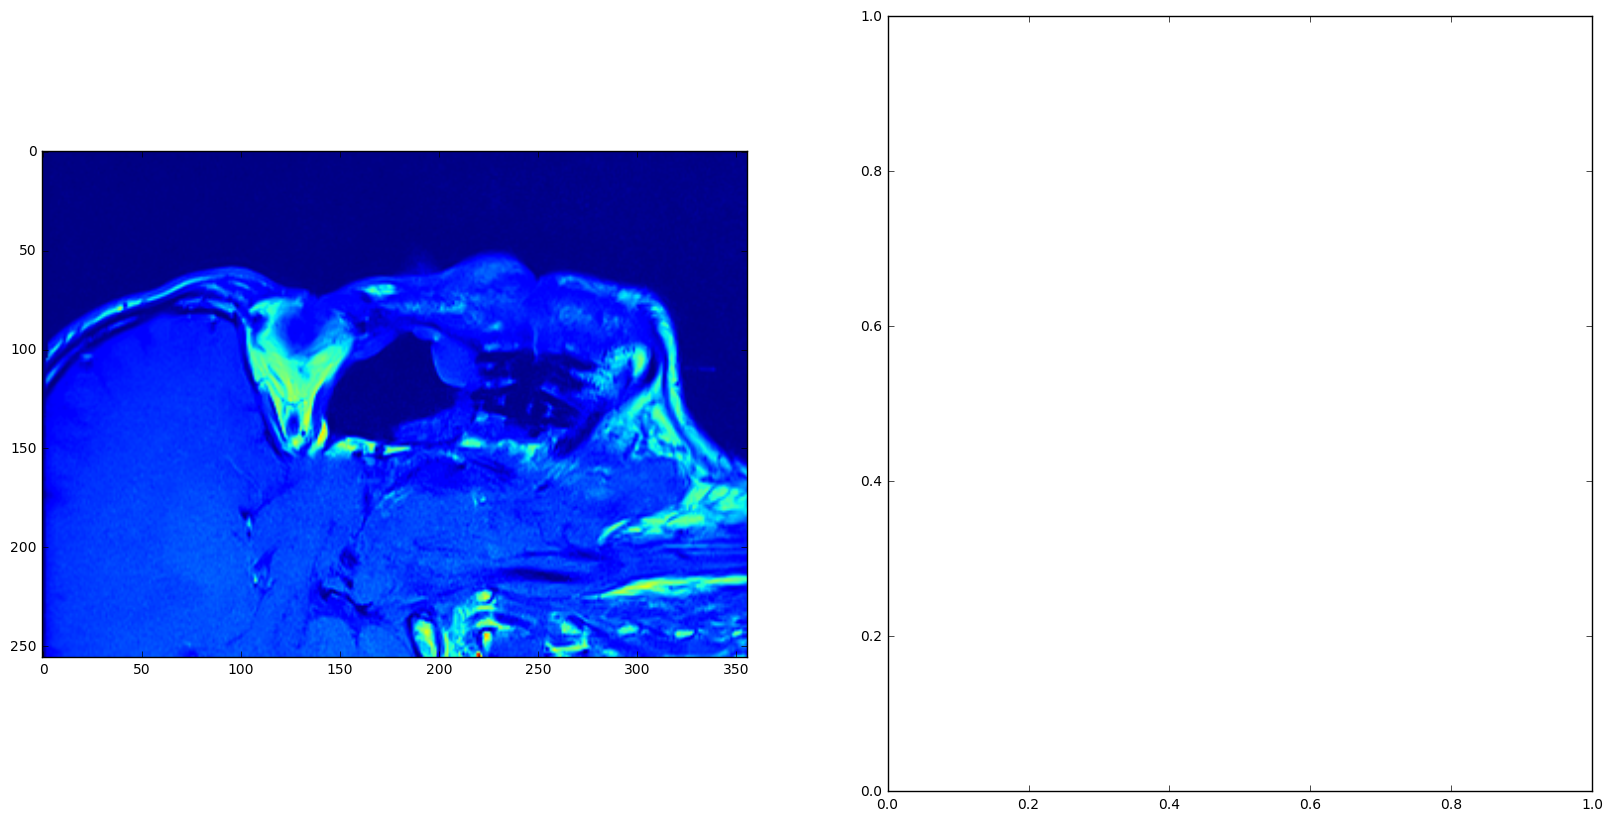

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
#big_image_list[0]
for i_img in little_image_list[0:1]:
    fig, axs = plt.subplots(1, len(backends), figsize = (20, 10))
    for c_ax, c_back in zip(axs, backends[1:]):
        stime = time()
        c_image = DiskMappedLazyImage(i_img, c_back)[0:256, 0:356]
        print(c_back, c_image.shape, "{}s for loading".format(time()-stime))
        c_ax.imshow(c_image)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

for c_ax, c_back in zip(axs, backends):
    c_image = DiskMappedLazyImage(i_img, c_back)
    for i in [0, c_image.shape[0]-20, c_image.shape[0]]:
        for j in [0, c_image.shape[1]-20, c_image.shape[1]]:
            try:
                o_shape = c_image[i:i+20, j:j+20].shape
            except:
                o_shape = 'Failed'
            print(c_back, (i,j), o_shape)

<class 'pyqae.nd.LazyImagePillowBackend'> (0, 0) (20, 20)
<class 'pyqae.nd.LazyImagePillowBackend'> (0, 364) (20, 20)
<class 'pyqae.nd.LazyImagePillowBackend'> (0, 384) Failed
<class 'pyqae.nd.LazyImagePillowBackend'> (364, 0) (20, 20)
<class 'pyqae.nd.LazyImagePillowBackend'> (364, 364) (20, 20)
<class 'pyqae.nd.LazyImagePillowBackend'> (364, 384) Failed
<class 'pyqae.nd.LazyImagePillowBackend'> (384, 0) Failed
<class 'pyqae.nd.LazyImagePillowBackend'> (384, 364) Failed
<class 'pyqae.nd.LazyImagePillowBackend'> (384, 384) Failed
<class 'pyqae.nd.LazyImageGDALBackend'> (0, 0) (20, 20)
<class 'pyqae.nd.LazyImageGDALBackend'> (0, 364) (20, 20)
<class 'pyqae.nd.LazyImageGDALBackend'> (0, 384) Failed
<class 'pyqae.nd.LazyImageGDALBackend'> (364, 0) (20, 20)
<class 'pyqae.nd.LazyImageGDALBackend'> (364, 364) (20, 20)
<class 'pyqae.nd.LazyImageGDALBackend'> (364, 384) Failed
<class 'pyqae.nd.LazyImageGDALBackend'> (384, 0) Failed
<class 'pyqae.nd.LazyImageGDALBackend'> (384, 364) Failed
<cla

In [7]:
in_lz_image = DiskMappedLazyImage(i_img, backends[-1])
dist_rdd = sc.parallelize([(in_lz_image, [(i,i+20), (j,j+20)]) for i in range(0, 100, 20) for j in range(0, 100, 20)])

In [8]:
def ext_img(x):
    dimg, ((xmin, xmax), (ymin, ymax)) = x
    return dimg[xmin:xmax, ymin:ymax]
all_imgs = dist_rdd.map(ext_img).collect()

In [9]:
dist_rdd2 = sc.parallelize([in_lz_image]*3).flatMap(lambda x: [ext_img((x,((i,i+20), (j,j+20)))) for i in range(0, 100, 20) for j in range(0, 100, 20)])
_ = dist_rdd2.collect()

In [10]:
help(paths_to_tiled_image)

Help on function paths_to_tiled_image in module pyqae.nd:

paths_to_tiled_image(paths, context=None, tile_size=(256, 256), padding=(0, 0), backend=<class 'pyqae.nd.LazyImageGDALBackend'>, skip_chunk=False, **kwargs)
    Create an tiled ND image from a collection of paths
    :param paths: List[str] / RDD[str] a list or RDD of strings containing image paths
    :param context: SparkContext the context to make the RDD from if paths is a list
    :param tile_size: the size of tiles to cut
    :param padding:  the padding to use
    :param backend: The LazyImageBackend to use for reading the image data in (by default uses the last one, GDAL if available)
    :param kwargs: other arguments for creating the initial RDD
    :return: a ChunkedRDD containing the image data as tiles (use .unchunk to make into a normal RDD)



In [11]:
dist_tile_rdd = paths_to_tiled_image(little_image_list[0:1], context = sc, backend = backends[-1])

In [12]:
in_lz_image = DiskMappedLazyImage(little_image_list[0], backends[-1])

In [13]:
dist_data = paths_to_tiled_image(little_image_list[0:1], context = sc, backend = backends[-1], skip_chunk = True)
print(dist_data)

Chunked BoltArray
shape: (1, 384, 384)



In [ ]:
dist_tile_rdd.tora

In [15]:
size = (256, 256)
padding = None
axis = (0,)
if dist_data.split == len(dist_data.shape) and padding is None:
    dist_data._rdd = dist_data._rdd.map(lambda kv: (kv[0]+(0,), array(kv[1], ndmin=1)))
    dist_data._shape = self._shape + (1,)
    dist_data._plan = (1,)
    dist_data._padding = array([0])
    print(dist_data)

rdd = dist_data._rdd
dist_data._plan, dist_data._padding = dist_data.getplan(size, axis, padding)
print('plan', dist_data._plan, 'padding', dist_data._padding)
if any([x + y > z for x, y, z in zip(dist_data.plan, dist_data.padding, dist_data.vshape)]):
    raise ValueError("Chunk sizes %s plus padding sizes %s cannot exceed value dimensions %s along any axis"
                     % (tuple(dist_data.plan), tuple(dist_data.padding), tuple(dist_data.vshape)))

if any([x > y for x, y in zip(dist_data.padding, dist_data.plan)]):
    raise ValueError("Padding sizes %s cannot exceed chunk sizes %s along any axis"
                     % (tuple(dist_data.padding), tuple(dist_data.plan)))

slices = dist_data.getslices(dist_data.plan, dist_data.padding, dist_data.vshape)
print('slices',slices)
from itertools import product
labels = list(product(*[list(enumerate(s)) for s in slices]))
scheme = [list(zip(*s)) for s in labels]
print('labels', labels)
print('scheme', scheme)
def _chunk(record):
    k, v = record[0], record[1]
    for (chk, slc) in scheme:
        if type(k) is int:
            k = (k,)
        yield k + chk, v[slc]

rdd = rdd.flatMap(_chunk)
rdd.mapValues(lambda x: x.shape).collect()

plan [256 384] padding [0 0]
slices [[slice(0, 256, 1), slice(256, 384, 1)], [slice(0, 384, 1)]]
labels [((0, slice(0, 256, 1)), (0, slice(0, 384, 1))), ((1, slice(256, 384, 1)), (0, slice(0, 384, 1)))]
scheme [[(0, 0), (slice(0, 256, 1), slice(0, 384, 1))], [(1, 0), (slice(256, 384, 1), slice(0, 384, 1))]]


[((0, 0, 0), (256, 384)), ((0, 1, 0), (128, 384))]

In [16]:
import pickle
in_lz_image.shape
in_lz_image.dtype
#print(len(pickle.dumps(dist_data)))
ipd = pickle.dumps(in_lz_image)
pickle.loads(ipd)

In [17]:
from pyqae import nd as nd_array
idf = nd_array.tensor_to_dataframe(dist_tile_rdd)

In [18]:
ivp = pickle.loads(pds)
ivp2 = pickle.loads(pds)
ivp.shape, ivp2.shape
ivp._bckend, ivp2._bckend, ivp._bckend._im_obj, ivp2._bckend._im_obj


NameError: name 'pds' is not defined

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = viz.show_image(dist_tile_rdd.unchunk()[0,0:100,0:100].toarray())

In [ ]:
from pyqae.rddviz import show_dag
show_dag(dist_tile_rdd.unchunk()[0,0:100,0:100].tordd(), 'tile_read.svg')

In [ ]:
dist_tile_rdd.unchunk()[0,0:100,0:100].toarray()

In [ ]:
dist_tile_rdd.unchunk()[0,0:100,0:100].tordd().first()

In [ ]:
def my_func(x):
    print(x[0], x[1].shape)
dist_tile_rdd.tordd().foreach(my_func)

In [ ]:
dist_tile_rdd.tordd().take(10)

In [ ]:
?sc.parallelize

In [ ]:
?paths_to_tiled_image